Color at (1538, 1187) is: [117 162 161]
Color at (1552, 797) is: [123 163 167]
Color at (874, 619) is: [127 151 134]
Color at (875, 630) is: [128 143 131]


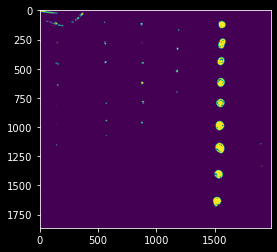

In [21]:
import PIL
import colorsys
from PIL import Image, ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Pillow image processing
# Open the image
image = Image.open(
    '''plate3-20220507-193901-night.png''')
# Crop the image to remove the left and right edges
left = 200
upper = 0
right = 3280 - 300
lower = 2464

# Crop the image to remove the top and bottom edges
crop_left_right = (left, upper, right, lower)
image = image.crop(crop_left_right)

# Let us make another crop to remove the petri dish edges
# We take advantage of the precision from the jig.
left = 400
upper = 200
right = 3280 - 900
lower = 2464 - 400

crop_gelatin = (left, upper, right, lower)
image = image.crop(crop_gelatin)

image.save("cropped.png") # Don't save the image when we do the whole set for performance.

# Now we want to identify the square edged of the petri dish so we can identify the yeast colonies. We choose to use OpenCV:
# Convert the PIL image to a numpy array
image_array = np.array(image)
# Convert the numpy array to a cv2 image. This will be a color image with BGR we can expose via matplotlib
cv2_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

# We'll try to preprocess the image to make it easier to read


def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pixel = cv2_image[y, x]
        print(f"Color at ({x}, {y}) is: {pixel}")
        colors.append(pixel)
        update_color_window()


def delete_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        index = x // color_block_width
        if index < len(colors):
            del colors[index]
            update_color_window()


def update_color_window():
    if not colors:  # Check if the colors list is not empty
        cv2.imshow('colors', np.zeros(
            (color_block_height, color_block_width, 3), dtype=np.uint8))
        return

    # Handle generating color blocks
    color_window = np.zeros(
        (color_block_height, color_block_width * len(colors), 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_window[:, i *
                     color_block_width:(i + 1) * color_block_width] = color
    cv2.imshow('colors', color_window)


colors = []
color_block_width = 50
color_block_height = 50

cv2.namedWindow('image', flags=cv2.WINDOW_NORMAL)
cv2.namedWindow('colors', flags=cv2.WINDOW_NORMAL)

cv2.setMouseCallback('image', pick_color)
cv2.setMouseCallback('colors', delete_color)

while True:
    cv2.imshow('image', cv2_image)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
# cid = plt.gcf().canvas.mpl_connect('button_press_event', pick_color)

cv2.destroyAllWindows()


# Generate color masks for each of the colors we selected in the image.
colors # -> [(b, g, r), ...]
hsv_colors = []
for color in colors:
    h, s, v = colorsys.rgb_to_hsv(*(color[::-1] / 255))
    # Convert hsv_color to OpenCV compatible HSV color
    # We're working with a 8-bit color depth, values are in [0, 255]
    h = int(h * 180)
    s = int(s * 255)
    v = int(v * 255)
    hsv_colors.append((h, s, v))

def create_color_mask(image, hsv_color: tuple, tolerance: int = 10):
    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
   # Create the color mask upper and lower bounds
    lower = (
        max(hsv_color[0] - tolerance, 0),
        max(hsv_color[1] - tolerance, 0),
        max(hsv_color[2] - tolerance, 0)
    )
    upper = (
        min(hsv_color[0] + tolerance, 180),
        min(hsv_color[1] + tolerance, 255),
        min(hsv_color[2] + tolerance, 255)
    )
    color_mask = cv2.inRange(hsv_image, lower, upper)
    return color_mask


hsv_masks = [create_color_mask(cv2_image, color, 20) for color in hsv_colors]

main_mask = np.zeros_like(hsv_masks[0])
for mask in hsv_masks:
    main_mask = cv2.bitwise_or(main_mask, mask)

plt.imshow(main_mask)

In [6]:

# This code is copied from MicroCV from github.com/ahmedfgad/MicroCV
# It is used to detect circles in the image but is not hooked up
cv2.namedWindow('image', flags=cv2.WINDOW_NORMAL)

window_name = 'image'
default_min_dist = 10
default_edge_threshold = 100
default_centre_threshold = 100
default_min_radius = 10
default_max_radius = 100

cv2.createTrackbar('threshold', 'image', 0, 255, lambda x: x)
cv2.createTrackbar("min_dist", window_name, default_min_dist, 50, lambda x: x)
cv2.createTrackbar("edge_threshold", window_name, default_edge_threshold, 150, lambda x: x)
cv2.createTrackbar("centre_threshold", window_name, default_centre_threshold, 150, lambda x: x)
cv2.createTrackbar("min_radius", window_name, default_min_radius, 40, lambda x: x)
cv2.createTrackbar("max_radius", window_name, default_max_radius, 100, lambda x: x)
while True:
    threshold = cv2.getTrackbarPos('threshold', 'image')
    min_dist = cv2.getTrackbarPos('min_dist', window_name)
    edge_threshold = cv2.getTrackbarPos('edge_threshold', window_name)
    centre_threshold = cv2.getTrackbarPos('centre_threshold', window_name)
    min_radius = cv2.getTrackbarPos('min_radius', window_name)
    max_radius = cv2.getTrackbarPos('max_radius', window_name)
    
    cv2.imshow('image', cv2_image)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
cv2.destroyAllWindows()

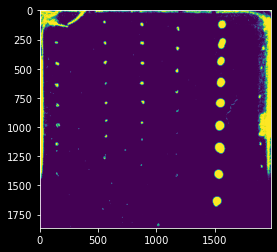

In [22]:
# This is also computationally expensive, don't run until we fix the bug
gray_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
t, edges = cv2.threshold(gray_image, 70, 255, cv2.THRESH_BINARY)

plt.imshow(edges)

# lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

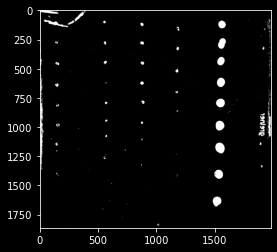

In [23]:
## This code is deprecated while we assume a sufficient crop will work instead.

cvcontours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# We also find circles
# circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
# cv2.drawContours(cv2_image, cvcontours , -1, (0,255,0), 3)

x_0, y_0, w_0, h_0 = 0, 0, 0, 0
for cnt in cvcontours:
    x,y,w,h = cv2.boundingRect(cnt)
    # get the max area
    if w_0 * h_0 < max(w_0 * h_0, w * h):
        x_0, y_0, w_0, h_0 = x, y, w, h
    
cv2.rectangle(cv2_image,(x_0,y_0),(x_0+w_0,y_0+h_0),(0,255,0),3)

plt.imshow(cv2_image)
plate_bounding_box = (x_0, y_0, w_0, h_0)

# Be able to grab colonies that are eccentric. Possibly two colonis that are touching.
# Grab the black 1 cm reference in the bottom right corner of the image
# The idea is to use EAST to detect the text. Then I can check the distortion on the scale reference
t, edges = cv2.threshold(gray_image, 10, 150, cv2.THRESH_BINARY_INV)
plt.imshow(edges, cmap='gray')

t, edges = cv2.threshold(gray_image, 79, 255, cv2.THRESH_BINARY)
cv2.rectangle(edges,(x_0,y_0),(x_0+w_0,y_0+h_0),(0,255,0),3)
# Here we combine edges and hsv masks
# We also use the plate bounding box to remove the plate from the image

combined_mask = cv2.bitwise_or(edges, main_mask)


plt.imshow(combined_mask, cmap='gray')

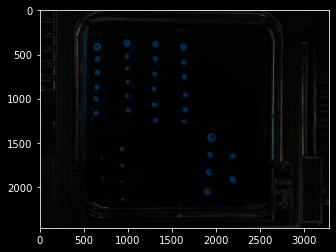

In [12]:
from pathlib import Path



def align_images(img1, img2):
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute ORB descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Compute homography
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Warp source image to destination
    h, w = img2.shape[:2]
    img1_aligned = cv2.warpPerspective(img1, M, (w, h))
    
    return img1_aligned

def diff_images(img1, img2):
    # Compute absolute difference
    diff = cv2.absdiff(img1, img2)
    return diff

image_path_1 = Path(r"G:\2022.05.10 spiro\2022.05.10 spiro\plate4\plate4-20220511-101302-night.png")

image_path_2 = Path(r"G:\2022.05.10 spiro\2022.05.10 spiro\plate4\plate4-20220512-124323-night.png")

# Load images
img1 = cv2.imread(str(image_path_1))
img2 = cv2.imread(str(image_path_2))

# Align images
img1_aligned = align_images(img1, img2)

# Diff images
diff = diff_images(img1_aligned, img2)

# Display diff
plt.imshow(diff)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

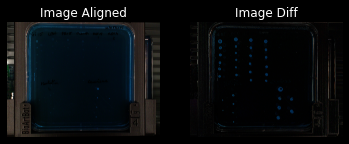

In [13]:
fig, axs = plt.subplots(1, 2)

# Show the images
axs[0].imshow(img1_aligned)
axs[0].set_title('Image Aligned')
axs[0].axis('off')  # Hide axes

axs[1].imshow(diff)
axs[1].set_title('Image Diff')
axs[1].axis('off')  # Hide axes

# Display the figure with the images
plt.show()

We try to correct the image for the perspective distortion:

In [ ]:
# We don't need the following because we use the precision from the gel plates
# To crop the image
# # Find the gel plate contour and corners
# gel_plate_contour = find_gel_plate_contour(contours)
# corners = find_gel_plate_corners(gel_plate_contour)
# # Order the corners (top-left, top-right, bottom-right, bottom-left)
# ordered_corners = order_corner_points(corners)
# # Define the target dimensions and corresponding points
# width, height = compute_target_dimensions(ordered_corners)
# target_points = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype=np.float32)
# Obtain the transformation matrix and apply the perspective transformation
# transformation_matrix = cv2.getPerspectiveTransform(ordered_corners, target_points)
# corrected_image = cv2.warpPerspective(image, transformation_matrix, (width, height))
